In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
import glob
import pickle
from src.utils import get_cfg_from_from_ckpt_path
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
import copy

In [2]:
plt.style.use('ggplot')

In [3]:
cmap = plt.get_cmap('viridis')

In [4]:
gpu = None
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [5]:
def load_model(model_ckpt_path: str,
               device: str):

    cfg = get_cfg_from_from_ckpt_path(model_ckpt_path, pprint = False)
    
    lit_mod = hydra.utils.call(cfg.model)

    lit_mod.load_state_dict(torch.load(model_ckpt_path)["state_dict"])


    lit_mod = lit_mod.to(device) # Move model to gpu for faster inference
    lit_mod = lit_mod.eval() # Model in eval mode
    for param in lit_mod.parameters():
        param.requires_grad = False  # Ensure no gradients are calculated for this model

    return lit_mod

In [6]:
def explicit_ecs(ssp: torch.tensor,
                 depth_tens: torch.tensor,
                 tau = 100):
    ssp = ssp.unsqueeze(1).nan_to_num()          
    kernel = torch.tensor([-1.0, 1.0]).float().view(1,1,2,1,1).to(ssp.device)
    derivative = F.conv3d(ssp, kernel, padding=(0,0,0))

    #sign = DF.differentiable_sign(derivative)

    sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()
    #print("After torch.sign (sign):", sign.requires_grad, sign.grad_fn)


    sign_diff = F.conv3d(sign, kernel, padding=(1,0,0))
    sign_change = F.tanh(10*F.relu(-sign_diff))

    for pattern in ([1, 0, 1], [1, -1, 0, 0]):  
        n = len(pattern)
        kernel_matrix = torch.eye(n)
        element_match = 0
        for i in range(n):
            kernel_element = kernel_matrix[i,:].view(1,1,n,1,1).to(ssp.device)
            element_match = element_match + (F.conv3d(sign, kernel_element, padding=(0,0,0)) - pattern[i])**2

        pattern_recognition = F.pad( element_match, (0, 0, 0, 0, 1, (sign_change.shape[2]- element_match.shape[2]) - 1),value=1.)    
        mask_discontinuity = 1 - F.relu(pattern_recognition+1) * F.relu(1-pattern_recognition)

        sign_change = sign_change * mask_discontinuity


    mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

    depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1,1,1).to(ssp.device).type(sign_change.dtype)
    depth_array_tens[0,0,0,0] = 0.  ##TODO the true first z value is equal to 48cm. It may have to be considered that way
    ecs_pred = (sign_change * mask ).squeeze(dim=1)
    ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values 
    return ecs_pred

In [7]:
n_components = 107

In [8]:
model = f"latent_dim_{n_components}_pooling_1_None"
ckpt_path = glob.glob(f"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_pool_2D/pred_1_var_0_ecs_0/latent_dim_{n_components}_pooling_1_None/None/**/*.ckpt",recursive=True)[0]

In [9]:
cfg = get_cfg_from_from_ckpt_path(ckpt_path, pprint = True)

```yaml

datamodule:
  _target_: src.data.BaseDatamodule
  dl_kw: {batch_size: '${model_config.batch_size.${dimensions}}', num_workers: 4}
  dtype_str: ${dtype}
  input_da: {_target_: src.utils.load_ssf_ecs_da, ecs_da_path: '${paths.variables}',
    ssf_da_path: '${paths.sound}'}
  x_max: ${normalization.x_max}
  x_min: ${normalization.x_min}
dimensions: 2D
dtype: float32
entrypoints:
- {_target_: pytorch_lightning.seed_everything, seed: 333}
- {_target_: src.train.base_training, dm: '${datamodule}', lit_mod: '${model}', trainer: '${trainer}'}
model:
  _target_: src.autoencoder_V2.AutoEncoder
  depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${paths.sound}'}
  loss_weight: {ecs_weight: 0, prediction_weight: 1, variation_weight: 0}
  model_hparams: ${model_config.model_hparams.${model.model_name}}
  model_name: ${model_architecture}_${dimensions}
  norm_stat: {x_max: '${normalization.x_max}', x_min: '${normalization.x_min}'}
  opt_fn: {T_max: '${trainer.max_epochs}', _partial_: true, _target_: src.ecs_classification.ECS_classification.cosanneal_lr_adamw,
    lr: 0.01, weight_decay: 0.001}
model_architecture: AE_CNN_pool
model_config:
  accumulate_grad_batches: {2D: 1, 3D: 4}
  batch_size: {2D: 4, 3D: 1}
  model_hparams:
    AE_CNN_2D:
      act_fn_str: Relu
      base_channels: 107
      batch_norm: false
      dropout_proba: 0.0
      dtype_str: float32
      latent_dim: 10
      num_layers: 4
      pooling_str: None
      spatial_dim: [107, 240, 240]
    AE_CNN_3D:
      act_fn_str: Relu
      base_channels: 1
      batch_norm: false
      dropout_proba: 0.0
      dtype_str: float32
      latent_dim: 10
      num_layers: 4
      pooling_str: None
      spatial_dim: [107, 240, 240]
    AE_CNN_pool_2D: {act_fn_str: None, dtype_str: float32, input_channels: 107, latent_dim: 107,
      num_layers: 1, pooling_str: None}
    ECS_explicit_pred_3D:
      depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${paths.sound}'}
normalization: {x_max: 1545.8698054910844, x_min: 1459.0439165829073}
paths: {sound: /DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc, variables: /DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_at_0_regrid_0_1000m.nc}
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  accumulate_grad_batches: ${model_config.accumulate_grad_batches.${dimensions}}
  callbacks:
  - {_target_: pytorch_lightning.callbacks.LearningRateMonitor}
  - {_target_: pytorch_lightning.callbacks.ModelCheckpoint, filename: '{val_loss:.2f}-{epoch:02d}',
    mode: min, monitor: val_loss, save_top_k: 1}
  - {_target_: pytorch_lightning.callbacks.EarlyStopping, check_on_train_epoch_end: true,
    min_delta: 0.0, monitor: val_loss, patience: 10, verbose: true}
  check_val_every_n_epoch: 1
  devices: 1
  inference_mode: false
  logger: {_target_: pytorch_lightning.loggers.tensorboard.TensorBoardLogger, log_graph: false,
    name: '${model.model_name}/pred_${model.loss_weight.prediction_weight}_var_${model.loss_weight.variation_weight}_ecs_${model.loss_weight.ecs_weight}',
    save_dir: "/homes/o23gauvr/Documents/th\xE8se/code/FASCINATION/outputs/AE_V2/",
    version: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}/${model.model_hparams.act_fn_str}/${now:%Y-%m-%d_%H-%M}'}
  max_epochs: 1000
  min_epochs: 0


```

In [10]:
dm = hydra.utils.call(cfg.datamodule) # will instantiate src.data.BaseDataModule with parameters specified in config
dm.setup(stage="fit") # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api
dm.setup(stage="test") # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api


In [11]:
depth_array = dm.train_dataloader().dataset.input.z.data

In [12]:
coords = dm.train_dataloader().dataset.input.coords

In [13]:
train_ssp_ds = dm.train_dataloader().dataset.input
train_ssp_ds_drop_na = train_ssp_ds.dropna(dim='lat')
train_ssp_arr = train_ssp_ds_drop_na.data
test_ssp_tens = torch.tensor(train_ssp_arr).float().to(device)
input_train_shape = train_ssp_arr.shape

test_ssp_ds = dm.test_dataloader().dataset.input
test_ssp_ds_drop_na = test_ssp_ds.dropna(dim='lat')
test_ssp_arr = test_ssp_ds_drop_na.data
test_ssp_tens = torch.tensor(test_ssp_arr).float().to(device)
input_test_shape = test_ssp_arr.shape

In [14]:
lit_model = load_model(ckpt_path, device)
ssp_pred = lit_model(test_ssp_tens)

In [15]:
pca = PCA(n_components = n_components, svd_solver = 'auto')
pca.fit(train_ssp_arr.transpose(0,2,3,1).reshape(-1,107))
output_test_decoded_pca =  pca.inverse_transform(pca.transform(test_ssp_arr.transpose(0,2,3,1).reshape(-1,input_test_shape[1]))).reshape(input_test_shape[0],input_test_shape[2],input_test_shape[3],-1).transpose(0,3,1,2)

In [16]:
ecs_truth = explicit_ecs(torch.tensor(test_ssp_arr).float(),torch.tensor(depth_array).float())
ecs_pred_pca = explicit_ecs(torch.tensor(output_test_decoded_pca).float(),torch.tensor(depth_array).float())
ecs_pred_ae = explicit_ecs(ssp_pred.float(),torch.tensor(depth_array).float())

In [17]:

#def get_AP_RMSE_per_ecs_class(model ,dm_dict,phase = 'test', device = 'cpu', from_ae = False , verbose = True):
ecs_class_dict = {
                "[0,0]":[],
                "]0,10[":[],
                "[10,20[":[],
                "[20,30[":[],
                "[30,40[":[],
                "[40,50[":[],
                "[50,60[":[],
                "[60,70[":[],
                "[70,80[":[],
                "[80,90[":[],
                "[90,100[":[],
                "[100,120[":[],
                "[120,150[":[],
                "[150,200[":[],
                "[200,250[":[],
                "[250,300[":[],
                "[300,700[":[],

            }

absolute_rmse_ecs_dict = {"pca": copy.deepcopy(ecs_class_dict),
                          "ae": copy.deepcopy(ecs_class_dict)}

relative_rmse_ecs_dict = {"pca": copy.deepcopy(ecs_class_dict),
                          "ae": copy.deepcopy(ecs_class_dict)}



rmse_ecs_pred_pca_flat = torch.sqrt((ecs_truth - ecs_pred_pca)**2).flatten()
rmse_ecs_pred_ae_flat = torch.sqrt((ecs_truth - ecs_pred_ae)**2).flatten()


ecs_true_flat = ecs_truth.flatten()

for i,ecs_true in enumerate(tqdm(ecs_true_flat)):
    
        
    if ecs_true == 0:
        absolute_rmse_ecs_dict["pca"]["[0,0]"].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[0,0]"].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[0,0]"].append(np.nan)
        relative_rmse_ecs_dict["ae"]["[0,0]"].append(np.nan)

    
    elif 0 < ecs_true < 10:
        absolute_rmse_ecs_dict["pca"]["]0,10["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["]0,10["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["]0,10["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["]0,10["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)

    elif 10 <= ecs_true < 20:
        absolute_rmse_ecs_dict["pca"]["[10,20["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[10,20["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[10,20["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[10,20["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)

        
    elif 20 <= ecs_true < 30:
        absolute_rmse_ecs_dict["pca"]["[20,30["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[20,30["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[20,30["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[20,30["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)
        
    elif 30 <= ecs_true < 40:
        absolute_rmse_ecs_dict["pca"]["[30,40["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[30,40["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[30,40["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[30,40["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)

        
    elif 40 <= ecs_true < 50:
        absolute_rmse_ecs_dict["pca"]["[40,50["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[40,50["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[40,50["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[40,50["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)
    
        
    elif 50 <= ecs_true < 60:
        absolute_rmse_ecs_dict["pca"]["[50,60["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[50,60["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[50,60["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[50,60["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)
        
    elif 60 <= ecs_true < 70:
        absolute_rmse_ecs_dict["pca"]["[60,70["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[60,70["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[60,70["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[60,70["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)
        
    elif 70 <= ecs_true < 80:
        absolute_rmse_ecs_dict["pca"]["[70,80["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[70,80["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[70,80["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[70,80["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)
        
    elif 80 <= ecs_true < 90:
        absolute_rmse_ecs_dict["pca"]["[80,90["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[80,90["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[80,90["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[80,90["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)
        
    elif 90 <= ecs_true < 100:
        absolute_rmse_ecs_dict["pca"]["[90,100["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[90,100["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[90,100["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[90,100["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)
        
    elif 100 <= ecs_true < 120:
        absolute_rmse_ecs_dict["pca"]["[100,120["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[100,120["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[100,120["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[100,120["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)

        
    elif 120 <= ecs_true < 150:
        absolute_rmse_ecs_dict["pca"]["[120,150["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[120,150["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[120,150["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[120,150["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)

        
    elif 150 <= ecs_true < 200:
        absolute_rmse_ecs_dict["pca"]["[150,200["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[150,200["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[150,200["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[150,200["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)

        
    elif 200 <= ecs_true < 250:
        absolute_rmse_ecs_dict["pca"]["[200,250["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[200,250["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[200,250["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[200,250["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)
        
    elif 250 <= ecs_true < 300:
        absolute_rmse_ecs_dict["pca"]["[250,300["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[250,300["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[250,300["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[250,300["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)

        
    elif 300 <= ecs_true < 700:
        absolute_rmse_ecs_dict["pca"]["[300,700["].append(rmse_ecs_pred_pca_flat[i])
        absolute_rmse_ecs_dict["ae"]["[300,700["].append(rmse_ecs_pred_ae_flat[i])
        relative_rmse_ecs_dict["pca"]["[300,700["].append(rmse_ecs_pred_pca_flat[i]/ecs_true)
        absolute_rmse_ecs_dict["ae"]["[300,700["].append(rmse_ecs_pred_ae_flat[i]/ecs_true)
        


100%|██████████| 1503360/1503360 [03:27<00:00, 7237.18it/s] 


TypeError: list indices must be integers or slices, not str

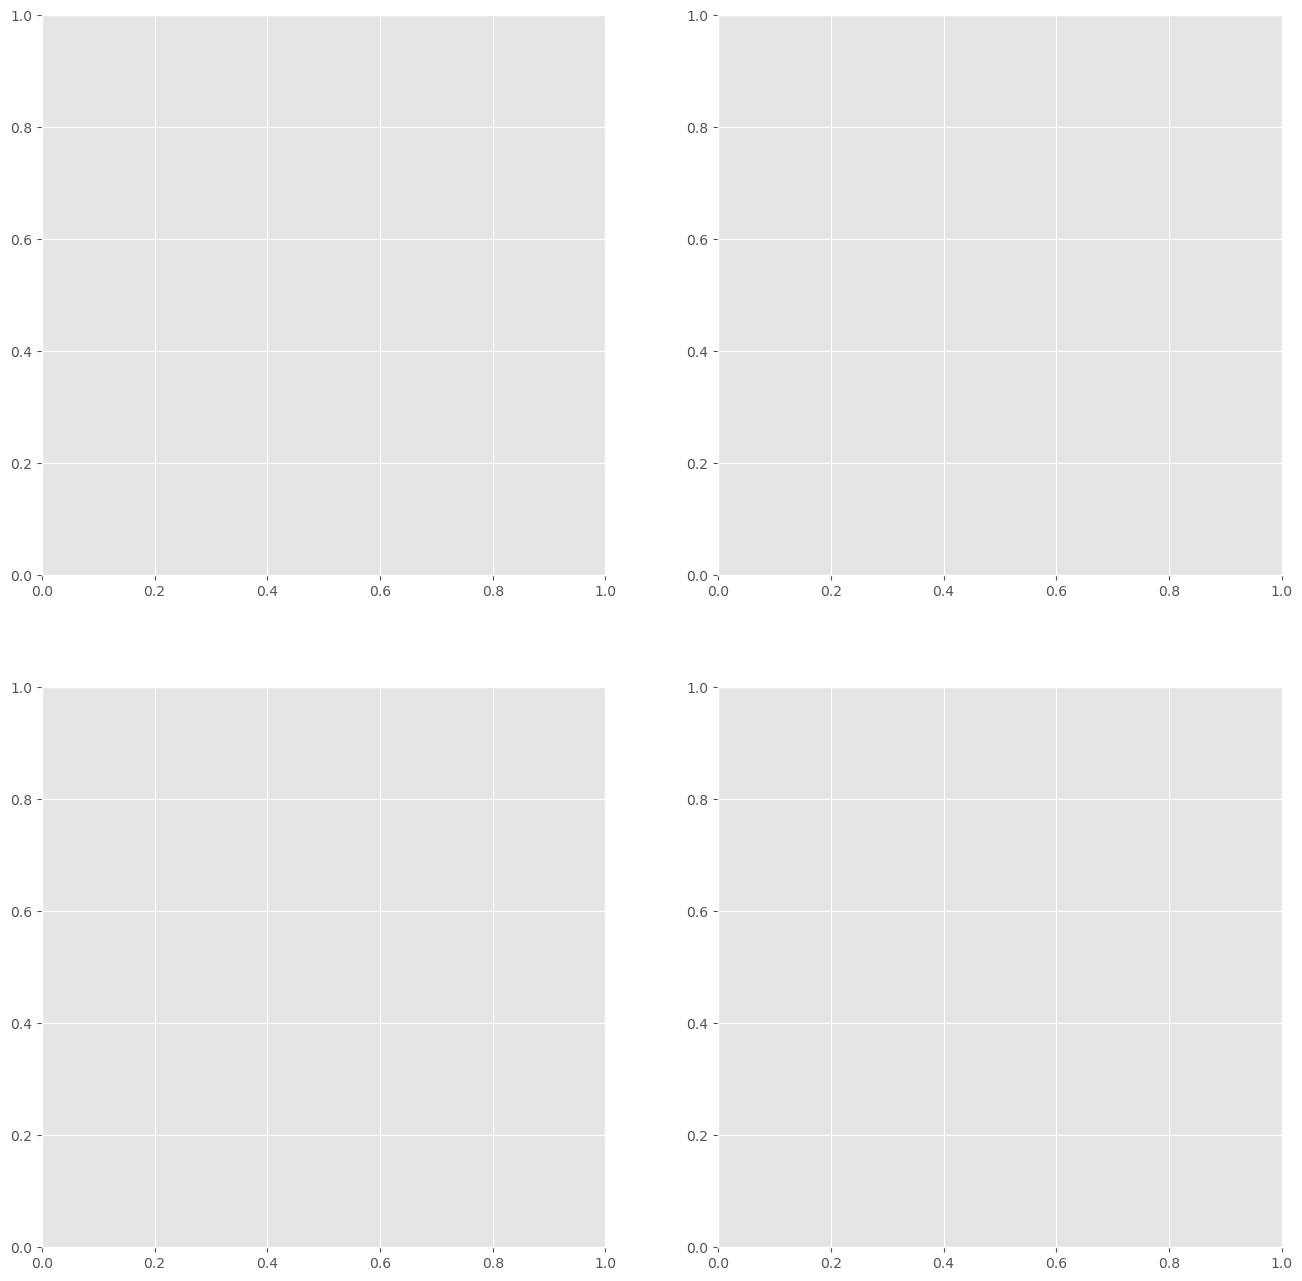

In [18]:
fig,axs = plt.subplots(2,2,figsize = (16,16))
#xticks_labels = list(ecs_class_rmse_dict.values()[0])
#n = len(xticks_labels)
for ap_shape, tuple_rmse in ecs_class_dict.items():
    
    absolute_rmse_ecs_means = [np.mean(rmse_list) for rmse_list in tuple_rmse["absolute_rmse"].values()]
    absolute_rmse_ecs_medians = [np.median(rmse_list) for rmse_list in tuple_rmse["absolute_rmse"].values()]


    relative_rmse_ecs_means = [np.mean(rmse_list) for rmse_list in tuple_rmse["relative_rmse"].values()]
    relative_rmse_ecs_medians = [np.median(rmse_list) for rmse_list in tuple_rmse["relative_rmse"].values()]
    
    n = len(absolute_rmse_ecs_means)
    
    axs[0,0].plot(np.arange(n),absolute_rmse_ecs_means, label=ap_shape)
    axs[0,1].plot(np.arange(n),absolute_rmse_ecs_medians, label=ap_shape)

    axs[1,0].plot(np.arange(n),relative_rmse_ecs_means, label=ap_shape)
    axs[1,1].plot(np.arange(n),relative_rmse_ecs_medians, label=ap_shape)


ecs_class = tuple_rmse["absolute_rmse"].keys()


for ax in axs[0,:]:

    ax.legend()
    ax.set_ylabel("RMSE (m)")
    ax.set_xticklabels(ecs_class)
    #ax.xaxis.set_tick_params(rotation=45)
    
for ax in axs[1,:]:

    ax.legend()
    ax.set_ylabel("RMSE (%)")
    ax.set_xticklabels(ecs_class)
    
    
    
axs[0,0].set_title("Mean of the absolute RMSE per ECS class")
axs[0,1].set_title("Median of the absolute RMSE per ECS class")
axs[1,0].set_title("Mean of the relative RMSE per ECS class")
axs[1,1].set_title("Median of the relative RMSE per ECS class")